# 08.영화 리뷰 텍스트 감성분석하기

In [1]:
import numpy as np
import tensorflow as tf
import os

In [2]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 01 데이터 준비

In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()#0 부정 1 긍정 

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 02 데이터로더 구성

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)#중복제거
    train_data = train_data.dropna(how = 'any') # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = [] #label, document 분리
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()#차원합치기
    counter = Counter(words)
    counter = counter.most_common(10000-4)#제일 많이 사용하는 단어개수 중복없이 9996개 가져오기 1단어 사전 0000개를 맞추기위해서
    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}#사전word_to_index 구성
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))#텍스트 스트링을 사전 인덱스 스트링으로 변환
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index 

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
# 인코더 디코더 구현
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 모든 문장은 <BOS>로 시작. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
print(len(word_to_index))#사전 길이 확인

10000


In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  
print(index_to_word[1909])
# 보정 후 x_train[0] 데이터
print(X_train[0], get_decoded_sentence(X_train[0], index_to_word))

<BOS>
1909
the
[32, 74, 919, 4, 4, 39, 228, 20, 33, 748] 더 빙 . . 진짜 짜증 나 네요 목소리


# 03 모델 구성을 위한 데이터 분석 및 가공

In [9]:
# 데이터셋 문장 길이 지정 
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

#  최대 길이를 (평균 + 2*표준편차)로 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
#패딩 추가 작업
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

# 04 모델 3가지 구성

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다
word_vector_dim = 300  # 워드 벡터의 차원 수

In [43]:
# RNN
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(tf.keras.layers.Dense(32, activation='relu'))
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 1,121,649
Trainable params: 1,121,649
Non-trainable params: 0
_________________________________________________________________


In [44]:
#GlobalMaxPooling1D 단일 레이어
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(32, activation='relu'))
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 1,003,505
Trainable params: 1,003,505
Non-trainable params: 0
_________________________________________________________________


In [45]:
# 1차원 cnn
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model3.add(tf.keras.layers.MaxPooling1D(5))
model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          44864     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          7184      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                

In [66]:
len(X_train)

146182

# 05 데이터 검증 set 분리, 훈련 시작

In [47]:
x_val = X_train[:10000]   
y_val = y_train[:10000]
# validation set을 제외한 나머지 130000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [48]:
import matplotlib.pyplot as plt

#훈련 및 시각화 함수

def train(model,epochs,partial_x_train,partial_y_train,x_val, y_val):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    history_dict = history.history # epoch에 따른 그래프를 그려볼 수 있는 항목들 history_dict.keys()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

    return model

# 06 각 모델 loss, accuracy 그래프 시각화

Epoch 1/10
266/266 [==============================] - 5s 12ms/step - loss: 0.4063 - accuracy: 0.8129 - val_loss: 0.3406 - val_accuracy: 0.8538
Epoch 2/10
266/266 [==============================] - 3s 10ms/step - loss: 0.3172 - accuracy: 0.8633 - val_loss: 0.3266 - val_accuracy: 0.8550
Epoch 3/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2825 - accuracy: 0.8796 - val_loss: 0.3271 - val_accuracy: 0.8603
Epoch 4/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2515 - accuracy: 0.8936 - val_loss: 0.3367 - val_accuracy: 0.8593
Epoch 5/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2260 - accuracy: 0.9058 - val_loss: 0.3458 - val_accuracy: 0.8577
Epoch 6/10
266/266 [==============================] - 3s 11ms/step - loss: 0.2037 - accuracy: 0.9163 - val_loss: 0.3653 - val_accuracy: 0.8564
Epoch 7/10
266/266 [==============================] - 3s 11ms/step - loss: 0.1824 - accuracy: 0.9261 - val_loss: 0.3878 - val_accuracy: 0.8554

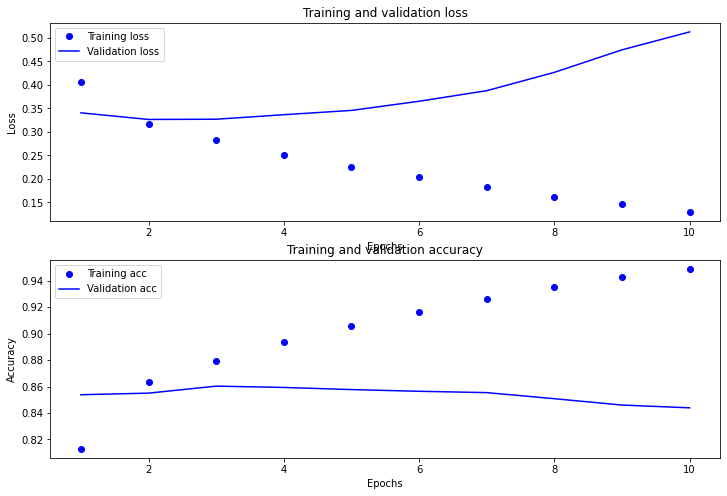

In [49]:
RNN = train(model1,7,partial_x_train,partial_y_train,x_val, y_val)

In [50]:
#평가 결과
results = RNN.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5106 - accuracy: 0.8431
[0.5105573534965515, 0.8430945873260498]


Epoch 1/10
266/266 [==============================] - 2s 4ms/step - loss: 0.4581 - accuracy: 0.7911 - val_loss: 0.3389 - val_accuracy: 0.8501
Epoch 2/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3077 - accuracy: 0.8714 - val_loss: 0.3329 - val_accuracy: 0.8528
Epoch 3/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2625 - accuracy: 0.8938 - val_loss: 0.3414 - val_accuracy: 0.8542
Epoch 4/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2223 - accuracy: 0.9132 - val_loss: 0.3634 - val_accuracy: 0.8531
Epoch 5/10
266/266 [==============================] - 1s 4ms/step - loss: 0.1829 - accuracy: 0.9318 - val_loss: 0.3948 - val_accuracy: 0.8498
Epoch 6/10
266/266 [==============================] - 1s 4ms/step - loss: 0.1439 - accuracy: 0.9485 - val_loss: 0.4531 - val_accuracy: 0.8448
Epoch 7/10
266/266 [==============================] - 1s 4ms/step - loss: 0.1103 - accuracy: 0.9627 - val_loss: 0.5077 - val_accuracy: 0.8403
Epoch 

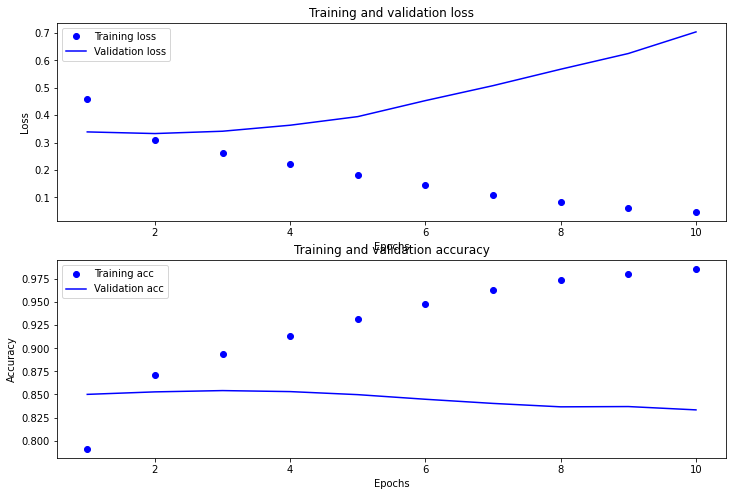

In [52]:
CNN_1D = train(model2,7,partial_x_train,partial_y_train,x_val, y_val)

In [53]:
results = CNN_1D.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7145 - accuracy: 0.8290
[0.7144884467124939, 0.8289561867713928]


Epoch 1/10
266/266 [==============================] - 3s 9ms/step - loss: 0.4214 - accuracy: 0.7978 - val_loss: 0.3322 - val_accuracy: 0.8556
Epoch 2/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2941 - accuracy: 0.8764 - val_loss: 0.3166 - val_accuracy: 0.8631
Epoch 3/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2338 - accuracy: 0.9071 - val_loss: 0.3320 - val_accuracy: 0.8589
Epoch 4/10
266/266 [==============================] - 2s 7ms/step - loss: 0.1630 - accuracy: 0.9411 - val_loss: 0.3825 - val_accuracy: 0.8516
Epoch 5/10
266/266 [==============================] - 2s 7ms/step - loss: 0.1004 - accuracy: 0.9667 - val_loss: 0.4584 - val_accuracy: 0.8438
Epoch 6/10
266/266 [==============================] - 2s 7ms/step - loss: 0.0620 - accuracy: 0.9805 - val_loss: 0.5585 - val_accuracy: 0.8477
Epoch 7/10
266/266 [==============================] - 2s 7ms/step - loss: 0.0402 - accuracy: 0.9875 - val_loss: 0.6414 - val_accuracy: 0.8383
Epoch 

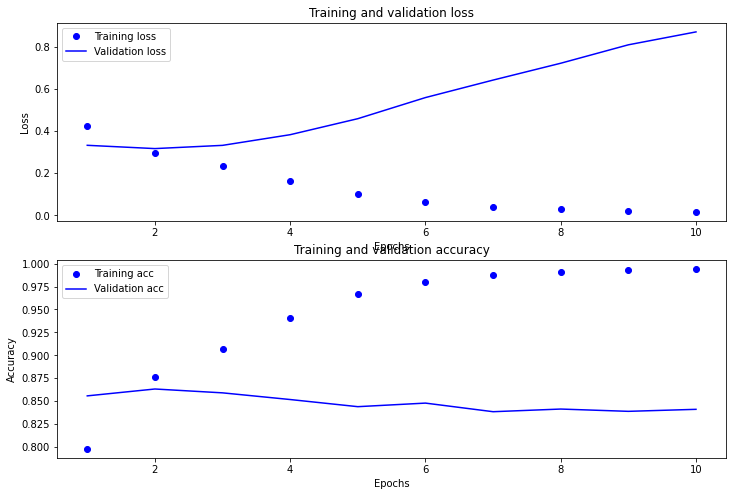

In [54]:
G_MP = train(model3,7,partial_x_train,partial_y_train,x_val, y_val)

In [55]:
results = G_MP.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8796 - accuracy: 0.8371
[0.8795537352561951, 0.837073028087616]


# 07 학습된 임베딩 레이어 분석

In [67]:
embedding_layer = RNN.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)#10000개의 사전, 단어를 표현한 300개의 차원 수 모두 적절하게 나옴

(10000, 100)


# 08 한국어 word2vec 임베딩 활용 성능 개선

In [56]:
!ln -s ~/data/word2vec_ko.model ~/aiffel/sentiment_classification/data
!ln -s ~/data/word2vec_ko.model.wv.vectors.npy ~/aiffel/sentiment_classification/data
!ln -s ~/data/word2vec_ko.model.trainables.syn1neg.npy ~/aiffel/sentiment_classification/data


ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model.wv.vectors.npy': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model.trainables.syn1neg.npy': File exists


In [57]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec = Word2VecKeyedVectors.load(os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model')#.wv.vectors.npy

In [68]:
word2vec.wv['끝']

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [69]:
word2vec.wv.most_similar(positive=['끝'], topn=5) #사전에 학습된 임베딩 레이어 성능 확인

[('마지막', 0.6325399875640869),
 ('결판', 0.5526015758514404),
 ('발목', 0.5465342402458191),
 ('산산조각', 0.5418900847434998),
 ('막바지', 0.5412753820419312)]

In [70]:
vocab_size = 10000    # 어휘 사전의 크기입니다
word_vector_dim = 100  # 워드 벡터의 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [71]:
from tensorflow.keras.initializers import Constant

In [75]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,embeddings_initializer=Constant(embedding_matrix),\
                                    input_shape=(None,),\
                                   input_length=maxlen, trainable=True))
model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 1,121,649
Trainable params: 1,121,649
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
266/266 [==============================] - 5s 12ms/step - loss: 0.4681 - accuracy: 0.7729 - val_loss: 0.3883 - val_accuracy: 0.8260
Epoch 2/10
266/266 [==============================] - 3s 10ms/step - loss: 0.3508 - accuracy: 0.8457 - val_loss: 0.3385 - val_accuracy: 0.8491
Epoch 3/10
266/266 [==============================] - 3s 10ms/step - loss: 0.3038 - accuracy: 0.8696 - val_loss: 0.3228 - val_accuracy: 0.8606
Epoch 4/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2739 - accuracy: 0.8844 - val_loss: 0.3209 - val_accuracy: 0.8603
Epoch 5/10
266/266 [==============================] - 3s 11ms/step - loss: 0.2471 - accuracy: 0.8975 - val_loss: 0.3203 - val_accuracy: 0.8640
Epoch 6/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2266 - accuracy: 0.9077 - val_loss: 0.3226 - val_accuracy: 0.8636
Epoch 7/10
266/266 [==============================] - 3s 11ms/step - loss: 0.2061 - accuracy: 0.9170 - val_loss: 0.3634 - val_accuracy: 0.8574

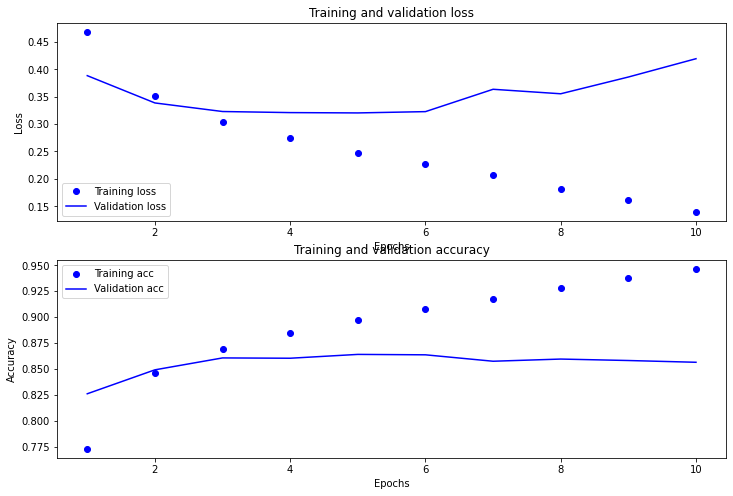

In [76]:
fine_model = train(model,8,partial_x_train,partial_y_train,x_val, y_val)

In [77]:
results = fine_model.evaluate(X_test,  y_test, verbose=2)

print(results)#학습률 85퍼 달성

1537/1537 - 4s - loss: 0.4263 - accuracy: 0.8521
[0.42627835273742676, 0.8521472215652466]


전체적으로 에포크 값을 조금만 올려도 오버 피팅이 자주 일어나서 weight decay 역할을 하는 레이어들이 필요하다고 생각한다

In [65]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
#word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
#f = open(word2vec_file_path, 'w')
#f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
#vectors = model.get_weights()[0]
#for i in range(4,vocab_size):
#    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
#f.close()